In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import sys
from bs4 import BeautifulSoup as bs

In [2]:
# Path to folder containg supplementary code.
sys.path.insert(1, '../../src')

import se_post_processing as sepp
import tokenizers as tkn
import config_reader as cr

# Table of Contents
---

### 1. Introduction
### 2. Data Processing
### 3. Modeling
### 4. Conclusion

# 1. Introduction
---

In this notebook, we create a baseline model for predicting whether or not a question on the Data Science Stack Exchange will be answered within 7 days. We first process the text and engineer features from the contents of the post, then we train and evaluate a logistic regression model.

# 2. Data Processing
---

We begin by preparing the Stack Exchange post data for modeling. We need to process and tokenize the text in the bodies and titles of the questions and dummify the tag variables. We also need to engineer features from the various HTML tags and the math equations found in the questions.

In [3]:
# Read data and insepct first five rows.
posts = pd.read_xml(cr.get_path('ds_posts'))
posts.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,ClosedDate,ContentLicense,AcceptedAnswerId,LastEditorUserId,LastEditDate,ParentId,OwnerDisplayName,CommunityOwnedDate,LastEditorDisplayName,FavoriteCount
0,5,1,2014-05-13T23:58:30.457,9,959.0,<p>I've always been interested in machine lear...,5.0,2014-05-14T00:36:31.077,How can I do simple machine learning without h...,<machine-learning>,...,2014-05-14T14:40:25.950,CC BY-SA 3.0,NaN,NaN,None,NaN,None,None,None,NaN
1,7,1,2014-05-14T00:11:06.457,4,503.0,"<p>As a researcher and instructor, I'm looking...",36.0,2014-05-16T13:45:00.237,What open-source books (or other materials) pr...,<education><open-source>,...,2014-05-14T08:40:54.950,CC BY-SA 3.0,10.0,97.0,2014-05-16T13:45:00.237,NaN,None,None,None,NaN
2,9,2,2014-05-14T00:36:31.077,5,NaN,"<p>Not sure if this fits the scope of this SE,...",51.0,2014-05-14T00:36:31.077,None,None,...,None,CC BY-SA 3.0,NaN,NaN,None,5.0,None,None,None,NaN
3,10,2,2014-05-14T00:53:43.273,13,NaN,"<p>One book that's freely available is ""The El...",22.0,2014-05-14T00:53:43.273,None,None,...,None,CC BY-SA 3.0,NaN,NaN,None,7.0,None,None,None,NaN
4,14,1,2014-05-14T01:25:59.677,26,1925.0,<p>I am sure data science as will be discussed...,66.0,2020-08-16T13:01:33.543,Is Data Science the Same as Data Mining?,<data-mining><definitions>,...,None,CC BY-SA 3.0,29.0,322.0,2014-06-17T16:17:20.473,NaN,None,None,None,NaN


In [4]:
# Convert `CreationDate` to date time.
posts['CreationDate'] = pd.to_datetime(posts['CreationDate'])

---

We need to separate the question posts from other kinds of posts and create a column which stores our target variable: whether or not a question was answered within 7 days of posting.

In [5]:
# Isolate questions in a separate data frame.
q_sel = posts['PostTypeId'] == 1
questions = posts.loc[q_sel, :]

In [6]:
# Isolate answers in a separate data frame.
a_sel = posts['PostTypeId'] == 2
answers = posts.loc[a_sel, :]

In [7]:
# Dates of first answers.
answer_dates = answers.groupby('ParentId')['CreationDate'].min().rename('AnswerDate')

# Merge first answer dates with questions.
questions = questions.merge(
    answer_dates,
    how='left',
    left_on='Id',
    right_index=True
)

In [8]:
# Question answer time.
answer_time = questions['AnswerDate'] - questions['CreationDate']

# Target column: was the question answered within 7 days?
questions['Answered7d'] = answer_time.dt.days <= 7

---

We wish to engineer several features for our predictive model. We first extract the hour of the day during which a question was posted, since questions posted during odd hours are more liable to be buried.

In [9]:
# Get hour of day from question creation time.
questions['CreationTime'] = questions['CreationDate'].dt.hour

We engineer a number of features which measure the types of content found in a question. These include the number of lines of code, the number of displayed math equations, and the number of lines of text in the post. We also count the number of various HTML tags that appear in questions, including `blockquote`, `ul`, and `img`.

The functions used to extract these features are in the imported Python module `se_post_processing.py`, which can be found in the `src` folder of the project directory.

In [10]:
# Count number of lines of code.
questions['CodeLines'] = questions['Body'] \
    .apply(sepp.count_code_lines)

# Count number of lines of text (excluding math and code).
questions['TextLines'] = questions['Body'] \
    .apply(sepp.count_text_lines)

# Count number of lines of displayed math equations.
questions['MathEquations'] = questions['Body'] \
    .apply(lambda x: len(sepp.find_math(x)))

# Count number of quote HTML tags.
questions['Quotes'] = questions['Body'] \
    .apply(lambda x: sepp.count_html_tags(x, 'blockquote'))

# Count number of bullet list HTML tags.
questions['BulletLists'] = questions['Body'] \
    .apply(lambda x: sepp.count_html_tags(x, 'ul'))

# Count number of image HTML tags.
questions['Images'] = questions['Body'] \
    .apply(lambda x: sepp.count_html_tags(x, 'img'))

---

The next step is to separate our data into training and test sets. We extract a random sample of $20\%$ of the data for testing.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Columns to be included as features.
feat_cols = [
    'CreationTime',
    'Title',
    'Body',
    'Tags',
    'CodeLines',
    'TextLines',
    'MathEquations',
    'Quotes',
    'BulletLists',
    'Images'
]

# Separate features and target variable.
X = questions.loc[:, feat_cols]
y = questions['Answered7d']

# Split into training and test sets.
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

---

We separate the lists of tags in the training questions into binary features representing whether a question contains given tags. We perform this feature engineering after splitting into training and test sets to avoid the possibility of the training data containing zero columns.

In [13]:
# Use regex to extract and explode the lists of tags and get the unique tags.
q_tag_lists = questions['Tags'].str.findall('<.*?>')
q_tags = q_tag_lists.explode().str.replace('<|>', '', regex=True)
unique_q_tags = q_tags.unique()

In [14]:
# Lists to store tag columns.
train_tag_cols = []
test_tag_cols = []

# Loop through the tags and create corresponding features for training and test data.
for tag in unique_q_tags:
    # Name for the tag column.
    col_name = f'Tag_{tag}'

    # Get questions with the given tag.
    tag_indices = q_tags[q_tags == tag].index

    # Create column in the training set indicating whether a question has the given tag.
    is_tagged_train = X_train.index.isin(tag_indices)
    is_tagged_train = pd.Series(
        data=is_tagged_train,
        index=X_train.index,
        dtype=int,
        name=col_name
    )

    # Create column in the test set indicating whether a question has the given tag.
    is_tagged_test = X_test.index.isin(tag_indices)
    is_tagged_test = pd.Series(
        data=is_tagged_test,
        index=X_test.index,
        dtype=int,
        name=col_name
    )

    train_tag_cols.append(is_tagged_train)
    test_tag_cols.append(is_tagged_test)


# Concatenate the tagg columns into a data frame.
tagged_df_train = pd.concat(train_tag_cols, axis=1)
tagged_df_test = pd.concat(test_tag_cols, axis=1)

# Concatenate the tag data frames with the training and test data frames.
X_train = pd.concat([X_train, tagged_df_train], axis=1).drop('Tags', axis=1)
X_test = pd.concat([X_test, tagged_df_test], axis=1).drop('Tags', axis=1)

---

Before modeling, we need to tokenize the titles and bodies of questions. We only include tokens consisting of alphabetic characters. We use lemmatization and exclude the standard English stopwords from ntlk. We vectorize the question titles and bodies as bags of words with tf-idf normalization. We use a maximum of 1,000 (10,000) features for the titles (bodies).

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [16]:
# Lemmatizer and list of stop words.
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words('english'))

# Title vectorizer
vectorizer_title = TfidfVectorizer(
    tokenizer=lambda title: tkn.tokenize_title(title, lemmatizer, stops),
    token_pattern=None,
    max_df = 0.7,
    min_df = 0.001,
    max_features=1000
)

# Body vectorizer
vectorizer_post = TfidfVectorizer(
    tokenizer=lambda post: tkn.tokenize_post(post, lemmatizer, stops),
    token_pattern=None,
    max_df = 0.7,
    min_df = 0.001,
    max_features=10000
)

In [17]:
# Create the bags of words.
bag_of_words_title = vectorizer_title.fit(X_train['Title'])
bag_of_words_post = vectorizer_post.fit(X_train['Body'])

C:\Users\ealwa\OneDrive\Documents\BrainStation\Projects\Capstone\BrainStation_Capstone\Notebooks\data_science\../../src\tokenizers.py:78: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 78 of the file C:\Users\ealwa\OneDrive\Documents\BrainStation\Projects\Capstone\BrainStation_Capstone\Notebooks\data_science\../../src\tokenizers.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = bs(post)


In [18]:
# Transform training words into data frames.

X_train_title_words = bag_of_words_title.transform(X_train['Title'])

X_train_title_words = pd.DataFrame(
    data=X_train_title_words.toarray(),
    index=X_train.index,
    columns=bag_of_words_title.get_feature_names_out()
)

X_train_post_words = bag_of_words_post.transform(X_train['Body'])

X_train_post_words = pd.DataFrame(
    data=X_train_post_words.toarray(),
    index=X_train.index,
    columns=bag_of_words_post.get_feature_names_out()
)


C:\Users\ealwa\OneDrive\Documents\BrainStation\Projects\Capstone\BrainStation_Capstone\Notebooks\data_science\../../src\tokenizers.py:78: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 78 of the file C:\Users\ealwa\OneDrive\Documents\BrainStation\Projects\Capstone\BrainStation_Capstone\Notebooks\data_science\../../src\tokenizers.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = bs(post)


In [19]:
# Transform test words into data frames.

X_test_title_words = bag_of_words_title.transform(X_test['Title'])

X_test_title_words = pd.DataFrame(
    data=X_test_title_words.toarray(),
    index=X_test.index,
    columns=bag_of_words_title.get_feature_names_out()
)

X_test_post_words = bag_of_words_post.transform(X_test['Body'])

X_test_post_words = pd.DataFrame(
    data=X_test_post_words.toarray(),
    index=X_test.index,
    columns=bag_of_words_post.get_feature_names_out()
)

C:\Users\ealwa\OneDrive\Documents\BrainStation\Projects\Capstone\BrainStation_Capstone\Notebooks\data_science\../../src\tokenizers.py:78: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 78 of the file C:\Users\ealwa\OneDrive\Documents\BrainStation\Projects\Capstone\BrainStation_Capstone\Notebooks\data_science\../../src\tokenizers.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = bs(post)


In [20]:
# Merge vectorized words into training set.
X_train = pd.concat(
    [X_train, X_train_title_words, X_train_post_words],
    axis=1
).drop(['Title', 'Body'], axis=1)

# Free memory.
del X_train_title_words
del X_train_post_words

In [21]:
# Merge vectorized words into test set.
X_test = pd.concat(
    [X_test, X_test_title_words, X_test_post_words],
    axis=1
).drop(['Title', 'Body'], axis=1)

# Free memory.
del X_test_title_words
del X_test_post_words

# 3. Modeling
---

With our data processing complete, we move on to modeling. We use a logistic regression model to predict whether or not a question is answered within 7 days. Our main reason for choosing logistic regression is computational efficiency (we have a large number of features) and interpretability. We would like to draw inferences from our model about how Stack Exchange users can structure their questions to maximize the odds of getting a timely answer.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [23]:
# Fit logistic regression model.
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

---

We investigate the 20 features which have the largest positive (negative) coefficient in our logistic regression model.

In [24]:
# Get coefficients with feature names.
coefs = pd.Series(
    data=lr.coef_[0],
    index=X_train.columns
).sort_values(ascending=False)

Text(0, 0.5, 'Coefficient')

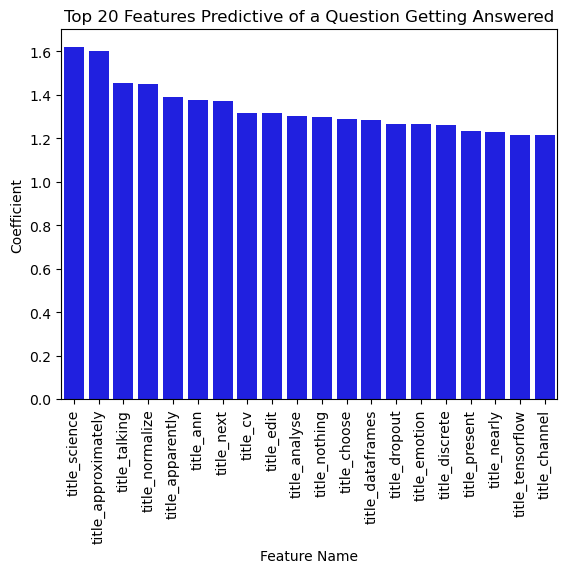

In [25]:
# Get top 20 positive coefficients.
pos_coefs = coefs[coefs > 0].sort_values(ascending=False)[:20]

# Plot top 20 positive coefficients.
ax = sns.barplot(
    x=pos_coefs.index,
    y=pos_coefs.values,
    color='blue'
)
ax.set_title('Top 20 Features Predictive of a Question Getting Answered')
ax.set_xlabel('Feature Name')
ax.set_xticks(range(20), labels=pos_coefs.index, rotation=90)
ax.set_ylabel('Coefficient')

We see the top 20 features with positive coefficients are all tokens the title of questions. One noteable feature is `title_dataframes`. Questions about data frames are likely to be relatively easy and thus be readily answered. Other features, such as `title_another` and `post_edit` seem highly suspect and indicative of flaws in our tokenizers.

Text(0, 0.5, 'Coefficient')

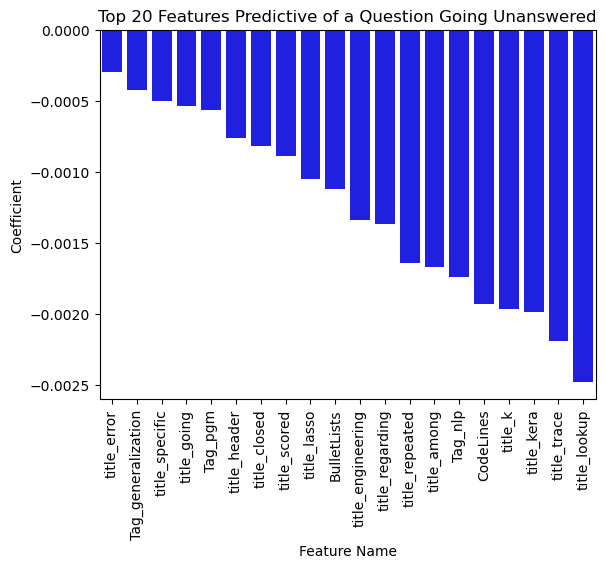

In [26]:
# Get top 20 negative coefficients.
neg_coefs = coefs[coefs < 0].sort_values(ascending=False)[:20]

# Plot top 20 negative coefficients.
ax = sns.barplot(
    x=neg_coefs.index,
    y=neg_coefs.values,
    color='blue'
)
ax.set_title('Top 20 Features Predictive of a Question Going Unanswered')
ax.set_xlabel('Feature Name')
ax.set_xticks(range(20), labels=neg_coefs.index, rotation=90)
ax.set_ylabel('Coefficient')

Among the top 20 features with negative coefficients, notable are several tag features, `CodeLines`, and `CreationTime`. The tag "data" seems too broad to be useful. The presence of the `CreationTime` feature suggests that questions posted later in the day are less likely to be answered. As for the presence of the `CodeLines` feature, it is likely that that too many lines of code makes a question too tedious to read.

In [27]:
# Training set class balance
y_train.value_counts(normalize=True).round(2)

Answered7d
True     0.66
False    0.34
Name: proportion, dtype: float64

In [28]:
# Test set class balance
y_test.value_counts(normalize=True).round(2)

Answered7d
True     0.66
False    0.34
Name: proportion, dtype: float64

In [29]:
# Model predictions.
train_predict = lr.predict_proba(X_train)[:, 1] >= 0.5
test_predict = lr.predict_proba(X_test)[:, 1] >= 0.5

# Test classification report.
train_cr = classification_report(y_train, train_predict)

# Test classification report.
test_cr = classification_report(y_test, test_predict)

# Print classification reports.
print('Train:')
print(train_cr)
print()
print('Test:')
print(test_cr)

Train:
              precision    recall  f1-score   support

       False       0.71      0.39      0.51     10096
        True       0.74      0.92      0.82     19337

    accuracy                           0.74     29433
   macro avg       0.73      0.66      0.66     29433
weighted avg       0.73      0.74      0.71     29433


Test:
              precision    recall  f1-score   support

       False       0.53      0.27      0.36      2528
        True       0.70      0.87      0.78      4831

    accuracy                           0.67      7359
   macro avg       0.61      0.57      0.57      7359
weighted avg       0.64      0.67      0.63      7359



The model performed reasonably well in terms of F1-score on the `1` class (question answered within 7 days), and accuracy on the training data was greater than the majority class share. However, recall on the `0` class was poor and precision on the `0` class was poor in the test set. Accuracy on the test set was equal to the majority class share.

# 4. Conclusion
---

Although our baseline can reasonably predict the positive outcome (a question is answered within 7 days), it is much less effective at predicting the negative outcome, especially on the test set. The accuracy drop between the training and test sets indicates some overfitting, which could be due to the large number of features. In the future, we will attempt dimensionality reduction, resampling, and using other types of models. Most significantly, we wish to improve our tokenization functions. A large amount of noise is being captured by our tokenizers, and we would like to include technical tokens, such as lines of code, which contain non-alphabetic characters.